# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.088901,True,5.422139
1,-0.900788,True,4.254737
2,-1.874952,False,-2.611583
3,-2.155776,False,-2.664398
4,0.704494,False,1.032854
...,...,...,...
995,-1.393274,False,-1.793297
996,-0.918474,False,-2.289546
997,-1.163178,False,-2.301462
998,-1.770846,False,-2.680135


<AxesSubplot:xlabel='v0'>

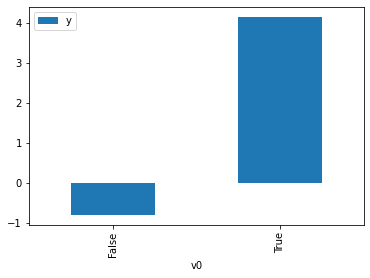

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

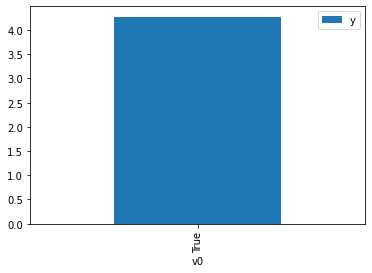

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.193818,False,3.395750,0.393856,2.538997
1,0.987758,False,2.209116,0.419499,2.383798
2,-0.912008,False,-2.218042,0.658179,1.519344
3,-0.046370,False,-0.796811,0.551971,1.811689
4,1.893054,False,2.815275,0.311773,3.207459
...,...,...,...,...,...
995,0.515730,False,1.561417,0.479679,2.084728
996,-0.966040,False,-0.226005,0.664422,1.505068
997,-0.722926,False,-1.304118,0.635908,1.572554
998,0.360479,False,2.467328,0.499690,2.001242


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.710807,True,3.986672,0.365540,2.735676
1,-0.689614,True,5.903564,0.368079,2.716805
2,-0.786670,True,4.926488,0.356513,2.804949
3,-0.067930,True,5.778453,0.445280,2.245778
4,-1.470779,True,1.294409,0.280206,3.568803
...,...,...,...,...,...
995,-2.254515,True,1.150399,0.206240,4.848724
996,0.027724,True,5.131284,0.457499,2.185797
997,-1.219173,True,2.330688,0.307114,3.256118
998,0.951901,True,7.625579,0.575990,1.736140


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              5518.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        22:11:08   Log-Likelihood:                         -1436.7
No. Observations:                1000   AIC:                                      2877.
Df Residuals:                     998   BIC:                                      2887.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5234      0.030     50.230      0.000       1.464       1.583
x2             4.9658      0.051     97.143      0.000       4.865       5.066
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.414
Skew:                          -0.003   Prob(JB):                        0.813
Kurtosis:                       3.100   Cond. No.                         1.71
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""